This notebook esimates FFH using image segmentation results from GSV pano images and corresponding depth maps, and conducts assessment of results using ground-truth data.

## Load modules
* Functions on geometry restoration are contained in the geometry.py module.

In [41]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [42]:
import numpy as np
import os
import glob
from PIL import Image
from GSV.geometry import extract_feature_pixels_lowest_region, calculate_height_difference, estimate_FFH, estimate_FFE
import geopandas as gpd
import matplotlib.pyplot as plt
from sklearn.metrics import root_mean_squared_error, mean_absolute_error
from tqdm import tqdm

## Set input folders of segmentation and depth images, ground-truth building points

In [43]:
in_folder_predictions=r'D:\Wagga\GSV\Pano_clipped_predicted'
in_folder_depth=r'D:\Wagga\GSV\Depth_clipped'
building_point_file=r'D:\Wagga\GSV\Final_Wagga_meta_camera_height_ground_elevations.geojson'

In [44]:
# # Launceston
# in_folder_predictions=r'D:\Launceston\GSV\Panos_clipped_predicted'
# in_folder_depth=r'D:\Launceston\GSV\Depth_clipped'
# building_point_file=r'D:\Launceston\GSV\LC_Final_meta_camera_height_ground_elevations.geojson'

## Read in ground-truth data

In [45]:
gdf=gpd.read_file(building_point_file)
gdf.head()

,WALL_M,STEPS,USAGE,STOREYS,ASSESSOR,address,Area_1,PMF,Dep_500,Dep_200,...,pitch,roll,elevation,date,height_c,grd_elev_GSV,grd_elev_building_min,grd_elev_building_mean,grd_elev_building_max,geometry
0,Metal,1,Commercial,1,ROBERT,3 MOORONG STREET,721.960449,3.6338,-9999.0000,-9999.0,...,-0.014912,6.252468,181.957260,2019-09,2.373121,178.93782,178.84587,178.96715,179.16086,POINT (531766.431 6115534.538)
1,Metal,1,Commercial,1,ROBERT,3 MOORONG STREET,314.036351,3.4780,-9999.0000,-9999.0,...,NaN,NaN,NaN,None,NaN,179.14285,178.90216,179.12869,179.32805,POINT (531713.009 6115541.678)
2,Metal,1,Commercial,1,ROBERT,UNIT 1 29 MOORONG STREET,1783.805231,3.2973,0.9431,-9999.0,...,NaN,NaN,NaN,None,NaN,178.91772,178.35599,178.93541,179.24902,POINT (531622.148 6115320.487)
3,Metal,1,Commercial,1,ROBERT,UNIT 1 29 MOORONG STREET,346.207850,4.6240,-9999.0000,-9999.0,...,0.002666,6.254132,181.549530,2019-09,2.824892,179.06947,178.97821,179.10648,179.21405,POINT (531707.773 6115277.767)
4,Metal,1,Commercial,1,ROBERT,11 MOORONG STREET,615.235606,3.4026,-9999.0000,-9999.0,...,0.003101,6.249268,181.555573,2019-09,2.439367,179.03090,178.84299,179.06560,179.15392,POINT (531756.903 6115457.675)


## Read in segmentation image and corresponding depth map

In [46]:
prediction_files = glob.glob(os.path.join(in_folder_predictions,'*.png'))
prediction_file=prediction_files[0]
lbl_arr = np.asarray(Image.open(prediction_file))

In [47]:
pano_id=os.path.basename(prediction_file).split('.')[0]
print(pano_id)

jBQ2YxuDk9nK9dOyL0LUKg


In [48]:
depth_file=os.path.join(in_folder_depth,os.path.basename(prediction_file).replace('.png','.tif'))
depth_arr=np.asarray(Image.open(depth_file))

## Extract building ground elevation, roadway elevation and camera height

In [49]:
building_elevation=gdf.loc[gdf['pano_id'] == pano_id, 'grd_elev_building_min'].values[0]
road_elevation=gdf.loc[gdf['pano_id'] == pano_id, 'grd_elev_GSV'].values[0]
height_camera=gdf.loc[gdf['pano_id'] == pano_id, 'height_c'].values[0]

In [50]:
# extract camera elevation from GSV metadata
# elev_camera=gdf.loc[gdf['pano_id'] == pano_id, 'elevation'].values[0]
# print(elev_camera)
elev_camera=height_camera+road_elevation

## FFH/FFE Estimation
### Extract class masks and derive feature top/bottom
- segmentation class pixel values: 1:"foundation", 2:"front door", 3:"garage door", 4:"stairs"

In [51]:
# extract bottom pixels of foundation, stairs, front door and garage door
foundation_mask=(lbl_arr==1)
frontdoor_mask = (lbl_arr==2)
garagedoor_mask = (lbl_arr==3)
stairs_mask = (lbl_arr==4)
foundation_bottom_pixels = extract_feature_pixels_lowest_region(foundation_mask,extract="bottom")
stairs_bottom_pixels = extract_feature_pixels_lowest_region(stairs_mask, extract="bottom")
frontdoor_bottom_pixels = extract_feature_pixels_lowest_region(frontdoor_mask,extract="bottom")
garagedoor_bottom_pixels = extract_feature_pixels_lowest_region(garagedoor_mask,extract="bottom")

# extract top pixels of foundation and stairs
foundation_top_pixels = extract_feature_pixels_lowest_region(foundation_mask,extract="top")
stairs_top_pixels = extract_feature_pixels_lowest_region(stairs_mask,extract="top")

### Calculate height difference between feature top/bottom and camera

In [52]:
H_img = depth_arr.shape[0]  # Height of the cropped panorama
delta_foundation_bottom = calculate_height_difference(foundation_bottom_pixels, depth_arr, H_img)
delta_stairs_bottom = calculate_height_difference(stairs_bottom_pixels, depth_arr, H_img)
delta_frontdoor_bottom = calculate_height_difference(frontdoor_bottom_pixels, depth_arr, H_img)
delta_garagedoor_bottom = calculate_height_difference(garagedoor_bottom_pixels, depth_arr, H_img)
delta_foundation_top = calculate_height_difference(foundation_top_pixels, depth_arr, H_img)
delta_stairs_top = calculate_height_difference(stairs_top_pixels, depth_arr, H_img)

### Calculate FFH/FFE

In [53]:
# # calculate FFH
# FFH = estimate_FFH(delta_foundation_top=delta_foundation_top, 
#                    delta_foundation_bottom=delta_foundation_bottom,
#                    delta_stairs_top=delta_stairs_top, 
#                    delta_stairs_bottom=delta_stairs_bottom, 
#                    delta_frontdoor_bottom=delta_frontdoor_bottom,
#                    delta_garagedoor_bottom=delta_garagedoor_bottom)
# print("Estimated First Floor Height (FFH):", FFH)

In [54]:
# calculate FFE
FFE = estimate_FFE(delta_foundation_top=delta_foundation_top, 
                        delta_stairs_top=delta_stairs_top, 
                        delta_frontdoor_bottom=delta_frontdoor_bottom,
                        delta_garagedoor_bottom=delta_garagedoor_bottom,
                        elev_camera=elev_camera)
FFH=FFE-building_elevation
# print("Estimated First Floor Elevation (FFE):", FFE)
print("Estimated First Floor Height (FFH):", FFH)

Estimated First Floor Height (FFH): 0.600547730501944


## Batch processing for all images
* This may take a while (more than an hour) depending on number of images to process.

In [ ]:
min_FFH_all_predicted=[]
mean_FFH_all_predicted=[]
max_FFH_all_predicted=[]
FFE_all_predicted=[]
pano_ids=[]
for prediction_file in prediction_files:
    # extract pano id
    pano_id=os.path.basename(prediction_file).split('.')[0]
    depth_file=os.path.join(in_folder_depth,os.path.basename(prediction_file).replace('.png','.tif'))
    if os.path.exists(depth_file):
        pano_ids.append(pano_id)
        print('pano id: ',pano_id)
        # read in corresponding depth map
        lbl_arr = np.asarray(Image.open(prediction_file))
        depth_arr=np.asarray(Image.open(depth_file))
        H_img = depth_arr.shape[0]  # Height of the cropped panorama
        
        # extract elevations of buildings and roadways
        min_building_elevation=gdf.loc[gdf['pano_id'] == pano_id, 'grd_elev_building_min'].values
        mean_building_elevation=gdf.loc[gdf['pano_id'] == pano_id, 'grd_elev_building_mean'].values
        max_building_elevation=gdf.loc[gdf['pano_id'] == pano_id, 'grd_elev_building_max'].values
        road_elevation=gdf.loc[gdf['pano_id'] == pano_id, 'grd_elev_GSV'].values
        height_camera=gdf.loc[gdf['pano_id'] == pano_id, 'height_c'].values
        if min_building_elevation.size>0 and road_elevation.size>0 and height_camera.size>0:
            elev_camera=height_camera[0]+road_elevation[0]
        # elev_camera=gdf.loc[gdf['pano_id'] == pano_id, 'elevation'].values
        # if elev_camera.size>0:
        #     elev_camera=elev_camera[0]
        # print(elev_camera)
            # extract bottom pixels of foundation, stairs, front door and garage door
            foundation_mask=(lbl_arr==1)
            frontdoor_mask = (lbl_arr==2)
            garagedoor_mask = (lbl_arr==3)
            stairs_mask = (lbl_arr==4)
            # foundation_bottom_pixels = extract_feature_pixels_lowest_region(foundation_mask,extract="bottom")
            # stairs_bottom_pixels = extract_feature_pixels_lowest_region(stairs_mask, extract="bottom")
            frontdoor_bottom_pixels = extract_feature_pixels_lowest_region(frontdoor_mask,extract="bottom")
            garagedoor_bottom_pixels = extract_feature_pixels_lowest_region(garagedoor_mask,extract="bottom")

            # extract top pixels of foundation and stairs
            foundation_top_pixels = extract_feature_pixels_lowest_region(foundation_mask,extract="top")
            stairs_top_pixels = extract_feature_pixels_lowest_region(stairs_mask,extract="top")

            # calculate height difference between feature top/bottom and camera
            # delta_foundation_bottom = calculate_height_difference(foundation_bottom_pixels, depth_arr, H_img)
            # delta_stairs_bottom = calculate_height_difference(stairs_bottom_pixels, depth_arr, H_img)
            delta_frontdoor_bottom = calculate_height_difference(frontdoor_bottom_pixels, depth_arr, H_img)
            delta_garagedoor_bottom = calculate_height_difference(garagedoor_bottom_pixels, depth_arr, H_img)
            delta_foundation_top = calculate_height_difference(foundation_top_pixels, depth_arr, H_img)
            delta_stairs_top = calculate_height_difference(stairs_top_pixels, depth_arr, H_img)
            
            # calculate FFH
            # FFH = estimate_FFH(delta_foundation_top=delta_foundation_top, 
            #                 delta_foundation_bottom=delta_foundation_bottom,
            #                 delta_stairs_top=delta_stairs_top, 
            #                 delta_stairs_bottom=delta_stairs_bottom, 
            #                 delta_frontdoor_bottom=delta_frontdoor_bottom,
            #                 delta_garagedoor_bottom=delta_garagedoor_bottom)
            # calculate FFE
            FFE = estimate_FFE(delta_foundation_top=delta_foundation_top, 
                        delta_stairs_top=delta_stairs_top, 
                        delta_frontdoor_bottom=delta_frontdoor_bottom,
                        delta_garagedoor_bottom=delta_garagedoor_bottom,
                        elev_camera=elev_camera)
            if FFE is not None:
                FFH_min=FFE-max_building_elevation[0]
                FFH_mean=FFE-mean_building_elevation[0]
                FFH_max=FFE-min_building_elevation[0]
                print("Estimated max First Floor Height (FFH):", FFH_min)
                print("Estimated mean First Floor Height (FFH):", FFH_mean)
                print("Estimated min First Floor Height (FFH):", FFH_max)
                # print("Estimated First Floor Elevation (FFE):", FFE)
                FFE_all_predicted.append(FFE)
                min_FFH_all_predicted.append(FFH_min)
                mean_FFH_all_predicted.append(FFH_mean)
                max_FFH_all_predicted.append(FFH_max)
    else:
        print('no depth map exists, skipping...')

pano id:  jBQ2YxuDk9nK9dOyL0LUKg
Estimated min First Floor Height (FFH): 0.600547730501944
Estimated mean First Floor Height (FFH): 0.1473877305019471
Estimated max First Floor Height (FFH): -0.2329622694980742
pano id:  s7Z0iqfymW-QZqNfFSoxbw
Estimated min First Floor Height (FFH): 0.2660594477842153
Estimated mean First Floor Height (FFH): 0.13786944778419752
Estimated max First Floor Height (FFH): -0.015100552215784546
pano id:  LCUF2Pubbz7QjdHfZW_GfA
Estimated min First Floor Height (FFH): 0.13745803188888317
Estimated mean First Floor Height (FFH): -0.07775196811110163
Estimated max First Floor Height (FFH): -0.2744119681111101
pano id:  J8FFfxdkr-vkjiub2B0O3g
Estimated min First Floor Height (FFH): 0.295074606941057
Estimated mean First Floor Height (FFH): 0.1570746069410518
Estimated max First Floor Height (FFH): 0.012444606941045322
pano id:  -o8pXZ3V8czHZFVxHeYuBA
Estimated min First Floor Height (FFH): 2.164420823073357
Estimated mean First Floor Height (FFH): 1.9751808230733

## Write estimated FFH/FFE back to building points file

In [65]:
gdf_updated=gdf.copy()
# pano_id_to_FFH=dict(zip(pano_ids, mean_FFH_all_predicted))
pano_id_to_FFH=dict(zip(pano_ids, max_FFH_all_predicted))
pano_id_to_FFE=dict(zip(pano_ids, FFE_all_predicted))
gdf_updated["FFH_GSV"] = gdf_updated['pano_id'].map(pano_id_to_FFH)
gdf_updated["FFE_GSV"] = gdf_updated['pano_id'].map(pano_id_to_FFE)

In [40]:
out_file=building_point_file.replace('.geojson','_FFH_GSV_new.geojson')
gdf_updated.to_file(out_file, driver="GeoJSON")

## Regression analysis and accuracy assessment
### FFH

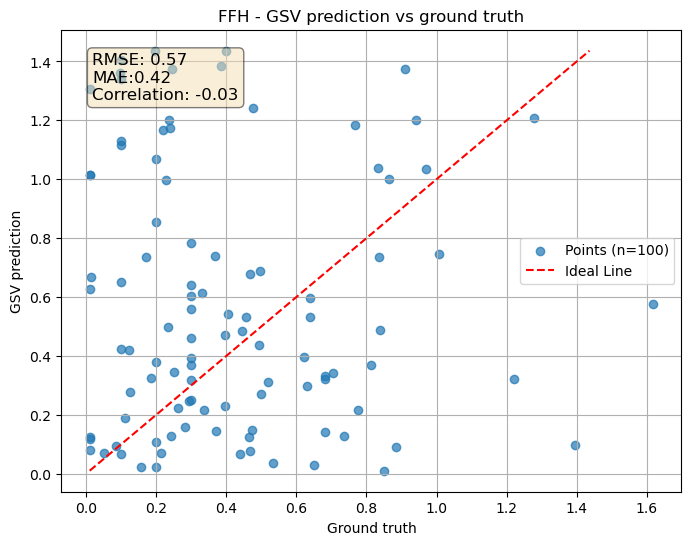

In [68]:
# filter out invalid prediction/groundtruth data
predicted_FFH=gdf_updated["FFH_GSV"]
gt_FFH=gdf_updated["Floor_height"]
# valid_indices = ~np.isnan(predicted_FFH) & ~np.isnan(gt_FFH)
# valid_indices = ~np.isnan(predicted_FFH) & ~np.isnan(gt_FFH) &(predicted_FFH!=0)& (gt_FFH!=0.28)
valid_indices = (predicted_FFH>0) & (predicted_FFH<1.5) & ~np.isnan(gt_FFH)& (gt_FFH!=0.28)
predicted_FFH = predicted_FFH[valid_indices]
gt_FFH = gt_FFH[valid_indices]

# Calculate RMSE and MAE
rmse = root_mean_squared_error(gt_FFH, predicted_FFH)
mae=mean_absolute_error(gt_FFH, predicted_FFH)
# Calculate Correlation Coefficient
correlation = np.corrcoef(gt_FFH, predicted_FFH)[0, 1]
# Plot scatter points
plt.figure(figsize=(8, 6))
plt.scatter(gt_FFH, predicted_FFH, alpha=0.7, label=f'Points (n={len(predicted_FFH)})')
# Add a line for ideal correlation (optional)
plt.plot([predicted_FFH.min(), predicted_FFH.max()],[predicted_FFH.min(), predicted_FFH.max()], 'r--', label='Ideal Line')
# Annotate RMSE and Correlation
plt.text(0.05, 0.95, f'RMSE: {rmse:.2f}\nMAE:{mae:.2f}\nCorrelation: {correlation:.2f}', 
         transform=plt.gca().transAxes, fontsize=12, 
         verticalalignment='top', bbox=dict(boxstyle="round", fc="wheat", ec="black", alpha=0.5))
# Labeling
plt.title('FFH - GSV prediction vs ground truth')
plt.xlabel('Ground truth')
plt.ylabel('GSV prediction')
plt.legend()
plt.grid()
# Show plot
plt.show()

### FFE

In [ ]:
# filter out invalid prediction/groundtruth data
predicted_FFE=gdf_updated["FFE_GSV"]
gt_FFE=gdf_updated["Floor_Leve"]
valid_indices = ~np.isnan(predicted_FFE) & ~np.isnan(gt_FFE)
predicted_FFE = predicted_FFE[valid_indices]
gt_FFE = gt_FFE[valid_indices]

# Calculate RMSE and MAE
rmse_FFE = root_mean_squared_error(gt_FFE, predicted_FFE)
mae_FFE=mean_absolute_error(gt_FFE, predicted_FFE)
# Calculate Correlation Coefficient
correlation_FFE = np.corrcoef(gt_FFE, predicted_FFE)[0, 1]
# Plot scatter points
plt.figure(figsize=(8, 6))
plt.scatter(gt_FFE, predicted_FFE, alpha=0.7, label=f'Points (n={len(predicted_FFE)})')
# Add a line for ideal correlation (optional)
plt.plot([predicted_FFE.min(), predicted_FFE.max()],[predicted_FFE.min(), predicted_FFE.max()], 'r--', label='Ideal Line')
# Annotate RMSE and Correlation
plt.text(0.05, 0.95, f'RMSE: {rmse_FFE:.2f}\nMAE:{mae_FFE:.2f}\nCorrelation: {correlation_FFE:.2f}', 
         transform=plt.gca().transAxes, fontsize=12, 
         verticalalignment='top', bbox=dict(boxstyle="round", fc="wheat", ec="black", alpha=0.5))
# Labeling
plt.title('FFH - GSV prediction vs ground truth')
plt.xlabel('Ground truth')
plt.ylabel('GSV prediction')
plt.legend()
plt.grid()
# Show plot
plt.show()

In [ ]:
len(predicted_FFH)